# 依赖

In [246]:
import pandas as pd
import tsfresh as tsf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
from sklearn.neighbors.kde import KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import datetime
import warnings
warnings.filterwarnings("ignore")

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer

%matplotlib inline

# 数据准备

In [252]:
data = pd.read_csv('../Data/123.csv')
data = data[['dateTime', 'iActual2', 'pha2']]
data = data.set_index('dateTime',drop=False)
data.index = pd.to_datetime(data.index)

In [253]:
data.describe()

,iActual2,pha2
count,407.000000,407.000000
mean,8.526757,43.410737
std,0.053127,1.313665
min,8.400000,40.790000
25%,8.490000,42.245000
50%,8.520000,43.410000
75%,8.560000,44.455000
max,8.800000,46.050000


In [319]:
xx,yy = np.meshgrid(np.arange(7,9,0.1),
                    np.arange(41,45,0.1))

In [321]:
xx,yy

(array([[7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2,
         8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9],
        [7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,

In [254]:
length = data.shape[0]
data['id'] = range(0,length)

In [255]:
data.axes

[DatetimeIndex(['2019-07-30 10:28:10.790000', '2019-07-30 10:28:53.090000',
                '2019-07-30 10:29:35.400000', '2019-07-30 10:39:22.510000',
                '2019-07-30 10:40:33.200000', '2019-07-30 10:47:00.500000',
                '2019-07-30 10:52:33.110000', '2019-07-30 10:53:55.690000',
                '2019-07-30 10:54:49.480000', '2019-07-30 10:56:41.800000',
                ...
                '2019-08-05 10:23:07.430000', '2019-08-05 10:23:49.790000',
                '2019-08-05 10:24:32.240000', '2019-08-05 10:25:16.410000',
                '2019-08-05 10:26:02.320000', '2019-08-05 10:28:03.420000',
                '2019-08-05 10:29:02.460000', '2019-08-05 10:31:28.570000',
                '2019-08-05 10:32:10.620000', '2019-08-05 10:43:56.140000'],
               dtype='datetime64[ns]', name='dateTime', length=407, freq=None),
 Index(['dateTime', 'iActual2', 'pha2', 'id'], dtype='object')]

In [256]:
data

,dateTime,iActual2,pha2,id
dateTime,,,,
2019-07-30 10:28:10.790,2019-07-30 10:28:10.790,8.44,43.67,0
2019-07-30 10:28:53.090,2019-07-30 10:28:53.090,8.52,42.57,1
2019-07-30 10:29:35.400,2019-07-30 10:29:35.400,8.59,44.71,2
2019-07-30 10:39:22.510,2019-07-30 10:39:22.510,8.51,44.31,3
2019-07-30 10:40:33.200,2019-07-30 10:40:33.200,8.44,42.56,4
...,...,...,...,...
2019-08-05 10:28:03.420,2019-08-05 10:28:03.420,8.49,43.94,402
2019-08-05 10:29:02.460,2019-08-05 10:29:02.460,8.50,43.46,403
2019-08-05 10:31:28.570,2019-08-05 10:31:28.570,8.54,41.14,404


In [257]:
data_A = data[['iActual2']]
data_P = data[['pha2']]

In [258]:
data_A = data_A.values
data_A = data_A.reshape(407,)

data_P = data_P.values
data_P = data_P.reshape(407,)

# 数据可视化

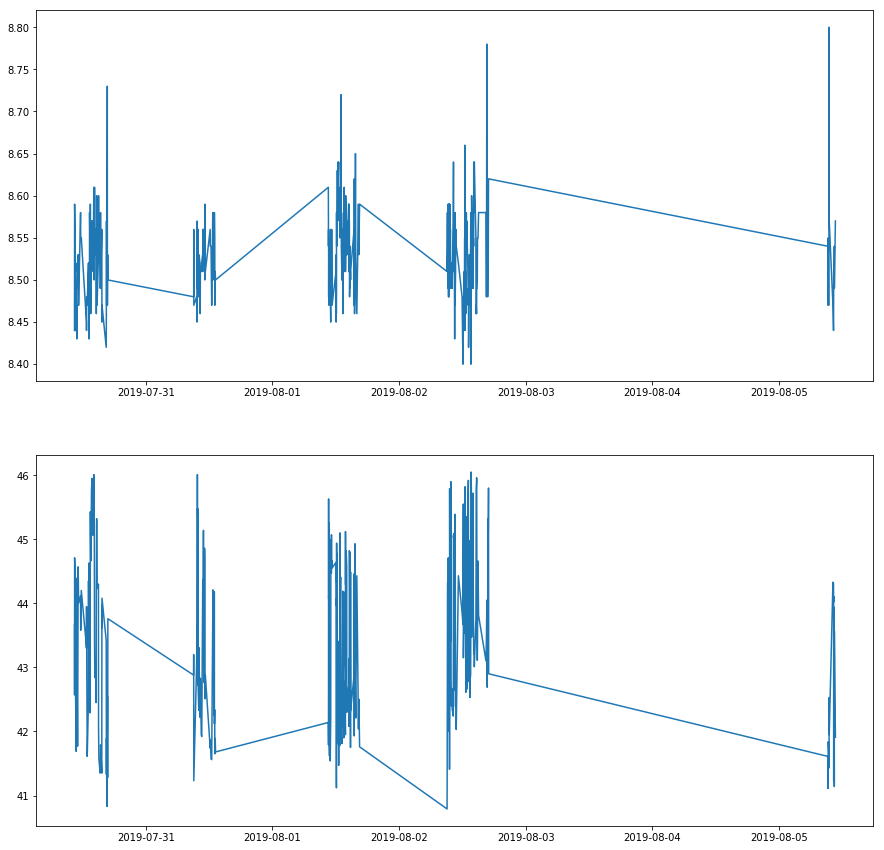

In [259]:
fig,axes=plt.subplots(2,1,figsize=(15,15))

ax1=axes[0]
ax2=axes[1]

ax1.plot(data['iActual2'])  
ax2.plot(data['pha2'])

从图像上看，数据没有明显的上升或下降的趋势和周期性,毛刺较多，需要做平滑。

# 时序检测

## 时间序列的周期性检测

### step1:平滑处理

时间序列经常会出现毛刺的点，需要做平滑处理才能分析，消除数据的毛刺，可以用移动平均法，但是移动平均有时候处理完后并不能使数据平滑

In [260]:
#平均移动线
data['iActual2_rolling_mean'] = data['iActual2'].rolling(window=15).mean()
data['pha2_rolling_mean'] = data['pha2'].rolling(window=15).mean()

#指数加权滑动
data['iActual2_rolling_ewma'] = data['iActual2'].ewm(span=15,ignore_na=True).mean()
data['pha2_rolling_ewma'] = data['pha2'].ewm(span=15,ignore_na=True).mean()

#log平滑
data['iActual2_log'] = np.log(data['iActual2'])
data['pha2_log'] = np.log(data['pha2'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016013B4E438>,
      dtype=object)

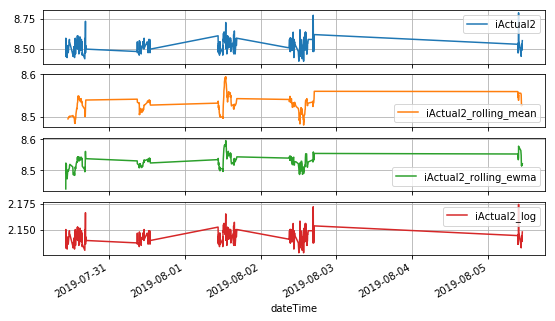

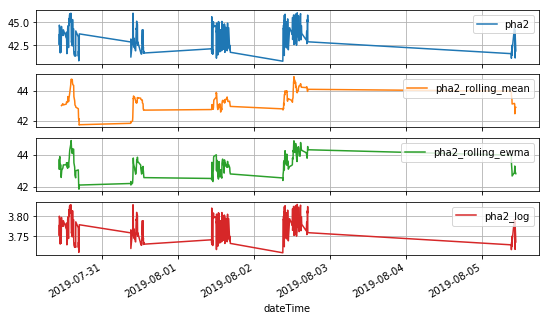

In [261]:
data[['iActual2', 'iActual2_rolling_mean','iActual2_rolling_ewma','iActual2_log']].plot(subplots=True, figsize=(9, 5), grid=True)
data[['pha2', 'pha2_rolling_mean','pha2_rolling_ewma','pha2_log']].plot(subplots=True, figsize=(9, 5), grid=True)

### step2:趋势、周期、残差分解

In [262]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['iActual2_log'],freq=20)

data['iActual2_trend'] = decomposition.trend
data['iActual2_seanoal'] = decomposition.seasonal
data['iActual2_residual'] = decomposition.resid

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000160197B1E80>,
      dtype=object)

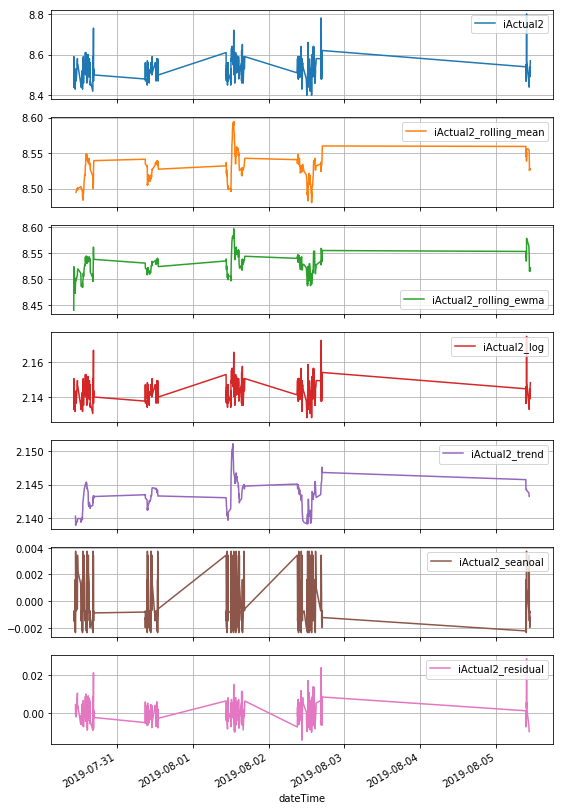

In [263]:
data[['iActual2', 'iActual2_rolling_mean','iActual2_rolling_ewma',
      'iActual2_log','iActual2_trend','iActual2_seanoal','iActual2_residual']].plot(subplots=True, figsize=(9, 15), grid=True)

## 单调趋势检验MK test

In [213]:
from timeseries_data_test.Mann_Kendall_trend import mk_test
t,h,p,z = mk_test(data_A,0.05)

In [214]:
t,h,p,z

('no trend', False, 0.6857867213188393, 0.4045793754754466)

## 平稳性检测ADF

In [215]:
def test_stationarity(timeseries):
  
    rolmean = timeseries.rolling(15).mean()
    rolstd = timeseries.rolling(15).std()
  
    # plot rolling statistics
    fig = plt.figure()
    fig.add_subplot()
    
    orig = plt.plot(timeseries,color='blue',label='Orignal')
    mean = plt.plot(rolmean,color='red',label='rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling standard deviation')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard deviation')
    plt.show(block=False)
    
    # Dickey_Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    timeseries1 = np.array(timeseries)
    print(timeseries1.shape)
    dftest = adfuller(timeseries1, autolag='AIC')
    # dftestd的abs输出前一项依次为检验值、p值、滞后数、使用的观测值、各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-values',
                                            '#Lags Used','Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    
    return dfoutput

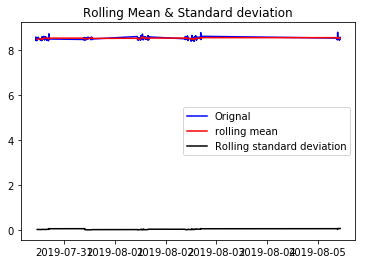

Results of Dickey-Fuller Test:
(407,)
Test Statistic                 -3.494757
p-values                        0.008123
#Lags Used                     17.000000
Number of Observation Used    389.000000
Critical value (1%)            -3.447273
Critical value (5%)            -2.868999
Critical value (10%)           -2.570743
dtype: float64


In [216]:
dfout = test_stationarity(data['iActual2'])
print(dfout)

Dickey-Fuller检验结果解读：p_value小于0.05，可以认为该序列为平稳时间序列，不需要再进行平稳化

## 白噪音检测

In [217]:
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts,lags=lag)
    
    return p_value

In [218]:
test_stochastic(data['iActual2'],[6,12])

(array([70.50784743, 79.29440805]), array([3.21681291e-13, 5.62557219e-12]))

白噪声检验结果解读：延迟6阶的p值<0.05，因此可以拒绝原假设，认为该序列不是白噪声序列

# 特征提取

In [219]:
series_A = pd.Series(data_A)
series_P = pd.Series(data_P)

## 物理特征

### 绝对能量值

In [220]:
ae = tsf.feature_extraction.feature_calculators.abs_energy(series_A)

### 近似熵

In [221]:
a_entropy=tsf.feature_extraction.feature_calculators.approximate_entropy(series_A, 407, 0.1)

### 分组熵

In [222]:
binned_entropy=tsf.feature_extraction.feature_calculators.binned_entropy(series_A, 10)

时序数据等距分组求熵

### Ricker小波分析

In [223]:
param = [ {'widths':tuple([2,2,2]), 'coeff': 2, 'w': 2}]
a_cwt=tsf.feature_extraction.feature_calculators.cwt_coefficients(series_A, param)
a_cwt= list(zip(a_cwt))[0][0][1]
a_cwt = round(a_cwt, 2)

连续的小波分析，ricker子波是地震勘探中常用的子波类型，ricker子波是基于波动方程严格推导得到的

### 傅里叶变换的频谱统计量

In [224]:
param = [{'aggtype': 'skew'}]
a_fft=tsf.feature_extraction.feature_calculators.fft_aggregated(series_A, param)
a_fft = list(zip(a_fft))[0][0][1]
a_fft = round(a_fft, 2)

傅里叶变换后的光谱质心、峰度、偏度等值

### 傅里叶变换系数

In [225]:
param = [{'coeff': 2, 'attr': 'angle'}]
a_fft_coef=tsf.feature_extraction.feature_calculators.fft_coefficient(series_A, param)
a_fft_coef = list(zip(a_fft_coef))[0][0][1]
a_fft_coef = round(a_fft_coef, 2)

In [226]:
a_fft_coef

-1.57

基于快速傅里叶变换算法计算一维离散傅里叶序列的系数

## 统计特征

描述时序数据的离原点的平方波动情况（能量）

### 一阶差分绝对和

In [227]:
asf = tsf.feature_extraction.feature_calculators.absolute_sum_of_changes(series_A)

描述时序数据相邻观测值之间的绝对波动情况

### 各阶自相关系数的聚合统计特征

In [228]:
param = [{'f_agg': 'mean', 'maxlag':2}]
agg_cor = tsf.feature_extraction.feature_calculators.agg_autocorrelation(series_A, param)
agg_cor = agg_cor[0][1]
agg_cor = round(agg_cor, 2)

In [229]:
agg_cor

0.26

统计时序数据各界差分间的聚合特征，依据不同的聚合函数，刻画时序数据的不同特征

### 线性回归

In [230]:
param = [{'attr': 'pvalue'}]
agg_liner=tsf.feature_extraction.feature_calculators.linear_trend(series_A,param)
agg_liner = list(zip(agg_liner))[0][0][1]
agg_liner = round(agg_liner, 2)

衡量时序数据的的周期性、不可预测性和波动性

### 自回归系数

In [231]:
param = [{'coeff': 0, 'k': 10}]
ar_coef =tsf.feature_extraction.feature_calculators.ar_coefficient(series_A, param)
ar_coef = ar_coef[0][1]
ar_coef = round(ar_coef, 2)
# ar_coef = list(zip(ar_coef))[0][0][1]
# ar_coef = round(ar_coef, 2)

In [232]:
ar_coef

4.61

衡量时序数据的的周期性、不可预测性和波动性

### ADF检验

In [233]:
param = [{'attr': 'pvalue'}]
a_adf=tsf.feature_extraction.feature_calculators.augmented_dickey_fuller(series_A, param)
a_adf = a_adf[0][1]
a_adf = round(a_adf, 2)

返回ADF检验统计值,测试一个自回归模型是否存在单位根，衡量时序数据的平稳性

### 时序数据复杂度

In [234]:
a_compcility=tsf.feature_extraction.feature_calculators.cid_ce(series_A, True)

用来评估时间序列的复杂度，越复杂的序列有越多的谷峰。

### 峰度

In [235]:
a_peak=tsf.feature_extraction.feature_calculators.kurtosis(series_A)

计算基于修正的Fisher-Pearson矩统计量的峰度,表征概率密度分布曲线在平均值处峰值高低的特征数

### 绝对差值的平均值

In [236]:
a_mac = tsf.feature_extraction.feature_calculators.mean_abs_change(series_A)

### 二阶导数的中心的均值

In [237]:
a_msdc = tsf.feature_extraction.feature_calculators.mean_second_derivative_central(series_A)

### 零交叉的数量

In [238]:
m = 7.8
a_ncm = tsf.feature_extraction.feature_calculators.number_crossing_m(series_A, m)

### 特征合并

In [300]:
data_input = data[['id','dateTime','iActual2']]
feature_extract = tsf.extract_features(data_input,column_id='id',column_sort='dateTime')

Feature Extraction: 100%|█████████████████████████| 10/10 [00:19<00:00,  2.41s/it]


In [240]:
# feature_extracted.shape

In [283]:
# need_list = ['abs_energy','absolute_sum_of_changes','agg_autocorrelation__f_agg_"mean"__maxlag_40',
#              'agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"','approximate_entropy__m_2__r_0.1',
#              'ar_coefficient__k_10__coeff_0','augmented_dickey_fuller__autolag_"AIC"__attr_"pvalue"','binned_entropy__max_bins_10',
#              'count_above_mean','count_below_mean','cid_ce__normalize_False','cid_ce__normalize_True',
#              'cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_2','fft_aggregated__aggtype_"skew"',
#              'fft_coefficient__coeff_2__attr_"angle"','linear_trend__attr_"pvalue"','number_crossing_m__m_1']

# columns_all = list(feature_extract.columns)
# columns_need = [x0 for x0 in columns_all for y in need_list if y in x0]

In [304]:
len(columns_need)
feature_need = feature_extract.copy()
# feature_extracted = feature_extracted.dropna()

In [305]:
feature_need

variable,iActual2__abs_energy,iActual2__absolute_sum_of_changes,"iActual2__agg_autocorrelation__f_agg_""mean""__maxlag_40","iActual2__agg_autocorrelation__f_agg_""median""__maxlag_40","iActual2__agg_autocorrelation__f_agg_""var""__maxlag_40","iActual2__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","iActual2__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","iActual2__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","iActual2__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","iActual2__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,iActual2__symmetry_looking__r_0.9,iActual2__symmetry_looking__r_0.9500000000000001,iActual2__time_reversal_asymmetry_statistic__lag_1,iActual2__time_reversal_asymmetry_statistic__lag_2,iActual2__time_reversal_asymmetry_statistic__lag_3,iActual2__value_count__value_-1,iActual2__value_count__value_0,iActual2__value_count__value_1,iActual2__variance,iActual2__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,71.2336,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.5904,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73.7881,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72.4201,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,71.2336,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,72.0801,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
403,72.2500,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,72.9316,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [306]:
feature_need2 = feature_need.dropna(axis=1)

In [307]:
feature_need2

variable,iActual2__abs_energy,iActual2__absolute_sum_of_changes,"iActual2__agg_autocorrelation__f_agg_""mean""__maxlag_40","iActual2__agg_autocorrelation__f_agg_""median""__maxlag_40","iActual2__agg_autocorrelation__f_agg_""var""__maxlag_40",iActual2__approximate_entropy__m_2__r_0.1,iActual2__approximate_entropy__m_2__r_0.3,iActual2__approximate_entropy__m_2__r_0.5,iActual2__approximate_entropy__m_2__r_0.7,iActual2__approximate_entropy__m_2__r_0.9,...,iActual2__symmetry_looking__r_0.9,iActual2__symmetry_looking__r_0.9500000000000001,iActual2__time_reversal_asymmetry_statistic__lag_1,iActual2__time_reversal_asymmetry_statistic__lag_2,iActual2__time_reversal_asymmetry_statistic__lag_3,iActual2__value_count__value_-1,iActual2__value_count__value_0,iActual2__value_count__value_1,iActual2__variance,iActual2__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,71.2336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72.5904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73.7881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72.4201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,71.2336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,72.0801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
403,72.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,72.9316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [308]:
feature_need2.columns

Index(['iActual2__abs_energy', 'iActual2__absolute_sum_of_changes',
       'iActual2__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'iActual2__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'iActual2__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'iActual2__approximate_entropy__m_2__r_0.1',
       'iActual2__approximate_entropy__m_2__r_0.3',
       'iActual2__approximate_entropy__m_2__r_0.5',
       'iActual2__approximate_entropy__m_2__r_0.7',
       'iActual2__approximate_entropy__m_2__r_0.9',
       ...
       'iActual2__symmetry_looking__r_0.9',
       'iActual2__symmetry_looking__r_0.9500000000000001',
       'iActual2__time_reversal_asymmetry_statistic__lag_1',
       'iActual2__time_reversal_asymmetry_statistic__lag_2',
       'iActual2__time_reversal_asymmetry_statistic__lag_3',
       'iActual2__value_count__value_-1', 'iActual2__value_count__value_0',
       'iActual2__value_count__value_1', 'iActual2__variance',
       'iActual2__variance_larger_than_s

# 异常检测

## 线性模型

In [310]:
data_std = standardizer(data[['iActual2','pha2']])

In [315]:
# Define the number of inliers and outliers
outliers_fraction = 0.20
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
n_samples,n_features = data_std.shape
y_range = np.zeros((n_features,2))
y_range[:,0] = np.min(data_std, axis=0)-1
y_range[:,1] = np.max(data_std, axis=0)+1
h = 0.1 # step size of the mash
x_min,x_max = y_range[0]
y_min,y_max = y_range[1]
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),
                    np.arange(y_min,y_max,h))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

TypeError: unsupported operand type(s) for -: 'str' and 'int'

### PCA

In [311]:
pca = PCA(random_state=42,outliers_fraction=0.2)

In [312]:
pca.fit(data_std)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

### MCD

最小协方差行列式，使用mahalanobis距离作为数据的离群度，种鲁棒性很强的位置和分布估计算法，并且可以通过FAST-MCD方法高效计算
assume_centered（bool）
True，则计算鲁棒位置和协方差估计的支持，并从中重新计算协方差估计，而不使数据居中。用于处理平均值显着等于零但不完全为零的数据。
False，则使用FastMCD算法直接计算稳健位置和协方差，无需额外处理

In [ ]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet


### OneClassSVM

OneCLassSVM不是一种outlier detection，而是一种novelty detection方法：它的训练集不应该掺杂异常点，因为模型可能会去匹配这些异常点。但在数据维度很高，或者对相关数据分布没有任何假设的情况下，OneClassSVM也可以作为一种很好的outlier detection方法。

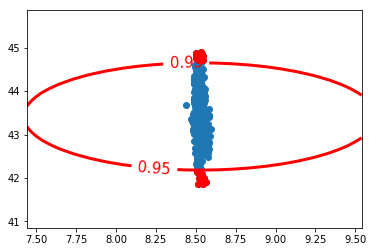

In [245]:
nu = 0.05
ocsvm = OneClassSVM(kernel='rbf',gamma=0.05, nu=nu)
ocsvm.fit(y)
y_outliers = y[ocsvm.predict(y)==-1]
Z_ocsvm = ocsvm.decision_function(grid)
Z_ocsvm = Z_ocsvm.reshape(xx.shape)
plt.figure()
c_0 = plt.contour(xx,yy,Z_ocsvm,levels=[0],colors='red', linewidths=3)
plt.clabel(c_0,inline=1,fontsize=15,fmt={0:str(alpha_set)})
plt.scatter(y['iActual2_rolling_ewma'],y['pha2_rolling_ewma'])
plt.scatter(y_outliers['iActual2_rolling_ewma'],y_outliers['pha2_rolling_ewma'],color='red')

## 基于邻近度的模型

### LOF

局部离群因子的异常检测算法LOF，它首先产生所有点的MinPts邻域及 MinPts距离，并计算到其中每个点的距离；对低维数据，利用网格进行k－NN查询，计算时间为O(n)；对中维或中高维数据，采用如X2树等索引结构，使得进行k2NN查询的时间为O(logn)，整个计算时间为O(nlogn)；对特高维数据，索引结构不再有效，时间复杂度提高到O(n2 )。然后计算每个点的局部异常因子，最后根据局部异常因子来挖掘离群。LOF算法中，离群点被定义为相对于全局的局部离群点，这与传统离群的定义不同，离群不再是一个二值属性(要么是离群点，要么是正常点),它摈弃了以前所有的异常定义中非此即彼的绝对异常观念，更加符合现实生活中的应用。基于密度检测方法。可量化每个数据点的异常程度。适用中等高维数据

### CBLOF

COF使用数据点的平均链接距离与数据点的k最近邻居的平均链接距离的平均值的比率作为观察的离群值得分。

### KNN

### HBOS

## 概率模型

### ABOD

## 集成框架

### IsolationForest

孤立森林是一个高效的异常点检测算法

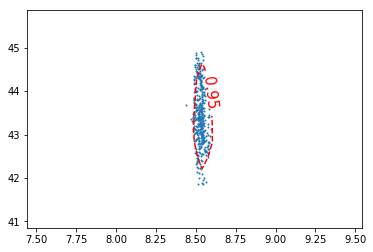

In [244]:
iforest = IsolationForest(n_estimators=300,contamination=0.10)
iforest = iforest.fit(y)

Z_iforest = iforest.decision_function(grid)
Z_iforest = Z_iforest.reshape(xx.shape)

plt.figure()
c_0 = plt.contour(xx,yy,Z_iforest,
                  levels=[iforest.threshold_],
                  colors='red',linewidth=3)
plt.clabel(c_0,inline=1, fontsize=15,
           fmt={iforest.threshold_:str(alpha_set)})
plt.scatter(y['iActual2_rolling_ewma'],y['pha2_rolling_ewma'],s=1.)

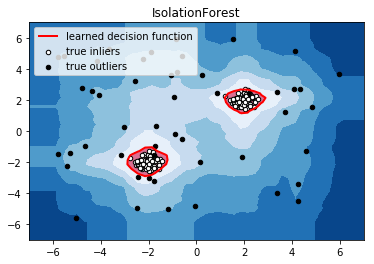

In [314]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# 构造训练样本
n_samples = 200  #样本总数
outliers_fraction = 0.25  #异常样本比例
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)

X = 0.3 * rng.randn(n_inliers // 2, 2)
X_train = np.r_[X + 2, X - 2]   #正常样本
X_train = np.r_[X_train, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]  #正常样本加上异常样本

# 构造模型并拟合
clf = IsolationForest(max_samples=n_samples, random_state=rng, contamination=outliers_fraction)
clf.fit(X_train)
# 计算得分并设置阈值
scores_pred = clf.decision_function(X_train)
threshold = np.percentile(scores_pred, 100 * outliers_fraction)  #根据训练样本中异常样本比例，得到阈值，用于绘图

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-7, 7, 50), np.linspace(-7, 7, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
# plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)  #绘制异常点区域，值从最小的到阈值的那部分
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')  #绘制异常点区域和正常点区域的边界
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')  #绘制正常点区域，值从阈值到最大的那部分

b = plt.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = plt.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.legend([a.collections[0], b, c],
           ['learned decision function', 'true inliers', 'true outliers'],
           loc="upper left")
plt.show()

### Feature Bagging

### LSCP

## 基于密度估计的异常检测

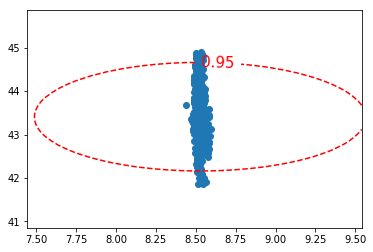

In [243]:
y = data[[ 'iActual2_rolling_ewma', 'pha2_rolling_ewma']]

kde = KernelDensity(kernel='gaussian')
kde = kde.fit(y)
kde_X = kde.score_samples(y)

alpha_set = 0.95
tau_kde = mquantiles(kde_X,1.-alpha_set)
n_samples,n_features = y.shape
y_range = np.zeros((n_features,2))
y_range[:,0] = np.min(y, axis=0)-1
y_range[:,1] = np.max(y, axis=0)+1
h = 0.1 # step size of the mash
x_min,x_max = y_range[0]
y_min,y_max = y_range[1]
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),
                    np.arange(y_min,y_max,h))

grid = np.c_[xx.ravel(),yy.ravel()]
Z_kde = kde.score_samples(grid)
Z_kde = Z_kde.reshape(xx.shape)
plt.figure()
c_0 = plt.contour(xx,yy,Z_kde,levels=tau_kde, colors='red',linewidth=3)
plt.clabel(c_0,inline=1,fontsize=15,fmt={tau_kde[0]:str(alpha_set)})
plt.scatter(y['iActual2_rolling_ewma'],y['pha2_rolling_ewma'])

## Autoencoder

# 参考资料